# Fine-Tuning BERT for Sentiment Analysis 

## Notes on the data

The data used in this study consists of 3000 customer reviews labeled into two classes: where label ”1” refers to a positive review and label ”0” refers to a negative review. For the purposes of this study, the data set was separated into a training set of 2400 samples and a testing set of 600 samples. 

## Other Notes

The attached "DataAnalysisScript.py" script should be run within the same directory as the "Words" directory. This directory contains the vocabulary and bag of words representations obtained from labeled amazon reviews (test.txt and train.txt) using the accompaning "prepossessingSentences.py" script. There is no need to said code here since I have already generated all the neccesary vocabulary files.

## Loading Main libraries

In [1]:
# Loading basic libraries
import warnings #prevent "future warning" errors
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import shutil
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
import re

#loading sklearn libraries
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

#changing default figure renderer for github display
import plotly.io as pio
pio.renderers
pio.renderers.default = "svg"

In [ ]:
!pip install tensorflow_datasets
!pip install -U tensorflow-text
!pip install -q tf-models-official
!pip install --upgrade plotly
!pip install -U kaleido

In [3]:
#loading tensorflow libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization 

# Data Proccesing 

## Loading data sets

In [4]:
#mounting google colab drive
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

# defining directory to store files
path = "/gdrive/MyDrive/Colab\ Notebooks/"

Mounted at /content/gdrive/


In [5]:
# defining function to read included txt files. 
def read_files(path):

  #initializing lists
  labels = []
  strings = []    
  index = []

  f = open(path, 'r')
  lines = f.readlines()

  for line in lines:

    #separating columns of data into indexes, strings, and labels
    labels.append(line.rsplit()[-1])
    index.append(line.rsplit()[0])
    string = line
    string = ' '.join(string.rsplit()[1:-1])

    #adding to list
    strings.append(string)

  dictionary = {'Sentences':strings, 'Labels':labels}
  df = pd.DataFrame(dictionary, index = index)
  df["Labels"] = pd.to_numeric(df["Labels"])
  df = df.sample(frac=1)

  return df

In [6]:
#reading data
train = read_files("gdrive/MyDrive/Colab Notebooks/Words/train.txt")
test = read_files("gdrive/MyDrive/Colab Notebooks/Words/test.txt")

#looking at data
print("training data shape: ", train.shape)
print("testing data shape: ", test.shape)

train.head(10)

training data shape:  (2400, 2)
testing data shape:  (600, 2)


,Sentences,Labels
1637,Coming here is like experiencing an underwhelm...,0
1847,I will never go back to this place and will ne...,0
437,Nice docking station for home or work.,1
401,"Good case, Excellent value.",1
264,I give Wirefly 1 star.I will contact Cingular/...,0
909,"If this premise sound stupid, that's because i...",0
744,Much less than the jawbone I was going to repl...,1
1361,I totally and absolutely recommend this movie ...,1
728,im surprised this is a good quality car charge...,1
683,"Small, sleek, impressive looking, practical se...",1


In [7]:
# converting data to tf dataset tensor 
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 2400

train_ds = tf.data.Dataset.from_tensor_slices((train["Sentences"], train["Labels"]))
test_ds = tf.data.Dataset.from_tensor_slices((test["Sentences"], test["Labels"]))

#Shuffling and dividing training data into batches
train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

#checking if conversion was done OK
for batch in train_ds.take(1):
  for row in batch[:][0][:2]:
    print(row)

  for label in batch[:][1][:2]:
    print(label)

tf.Tensor(b'This is the place where I first had pho and it was amazing!!', shape=(), dtype=string)
tf.Tensor(b"Uncomfortable In the Ear, Don't use with LG VX9900 (EnV).", shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


In [8]:
#alternativley, converting data to numpy array

train_x = train["Sentences"].to_numpy()
train_y = train["Labels"].to_numpy()

test_x = test["Sentences"].to_numpy()
test_y = test["Labels"].to_numpy()

#checking if conversion was done OK
for i in range(10):
  print(train_x[i],train_y[i])

Coming here is like experiencing an underwhelming relationship where both parties can't wait for the other person to ask to break up. 0
I will never go back to this place and will never ever recommended this place to anyone! 0
Nice docking station for home or work. 1
Good case, Excellent value. 1
I give Wirefly 1 star.I will contact Cingular/AT&T; and inform them of this practice. 0
If this premise sound stupid, that's because it is. 0
Much less than the jawbone I was going to replace it with. 1
I totally and absolutely recommend this movie to anyone who likes good wholesome family movies because that is exactly what this is. 1
im surprised this is a good quality car charger and there's not much reviews about it. 1
Small, sleek, impressive looking, practical setup with ample storage in place. 1


## Choosing BERT model to create embeddings

The included dictonaries are included for easy access to alternative models 



In [9]:
#defining dictionaries
map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
}

map_model_to_preprocess = {   
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

In [10]:
#choosing model
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

#finding related preproccesors and encoders
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

#loading preproccesor model
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess,name='preprocess')

#choosing encoder model
bert_model = hub.KerasLayer(tfhub_handle_encoder,trainable=True,name='encoder')

#printing choices
print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


# Testing pre-proccesing and encoding the data 
(code modified from https://www.tensorflow.org/text/tutorials/classify_text_with_bert?version=nightly)

In [11]:
#testing pre-proccesing the data
temp = ["I will never buy this item again!"]

temp_preprocces = bert_preprocess_model(temp)

print(f'Keys       : {list(temp_preprocces.keys())}')
print(f'Shape      : {temp_preprocces["input_word_ids"].shape}')
print(f'Word Ids   : {temp_preprocces["input_word_ids"][0, :12]}')
print(f'Input Mask : {temp_preprocces["input_mask"][0, :12]}')
print(f'Type Ids   : {temp_preprocces["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1045 2097 2196 4965 2023 8875 2153  999  102    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
#testing encoding the data
temp_results = bert_model(temp_preprocces)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{temp_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{temp_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{temp_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{temp_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.66916597  0.99434406 -0.53204316  0.05034159  0.7883574   0.608201
  0.98778874 -0.99891245 -0.65899855 -0.9997528  -0.02892545 -0.9816345 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.03490189  0.22657266  0.4805516  ... -0.32216778  1.4762723
   0.24345133]
 [-0.14663199  1.4872807  -0.28279895 ... -0.6117      0.8384829
  -0.04838954]
 [-0.41417813  0.6729794  -1.4870961  ... -0.5815437   0.1650127
   1.2022147 ]
 ...
 [-0.1594646   0.294144    0.7829197  ... -0.8159708   1.5213435
   0.18805006]
 [-0.07993805 -0.4246581   0.04261737 ...  0.09465174  0.9633994
   0.3636647 ]
 [-0.1249979  -0.27277327 -0.08296376 ... -0.00683095  1.0517676
   0.20736562]]


It looks like we are able to encode our test sentence pretty well.

# Building the Model Classifier 

## Creating pipeline to create classifier

In [13]:
def classifier_pipeline(intermediate_layers,num_units):
  
  #defining input layer
  input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input')

  #pre-proccesing the data
  pre = bert_preprocess_model(input)

  #encoding the data
  encoded = bert_model(pre)
  out = encoded["pooled_output"]
  #out = encoded["sequence_output"]

  #creating a neural network
  nn = out
  nn = tf.keras.layers.Dropout(0.1)(nn)

  #intermediate layers
  for i in range(intermediate_layers):
    nn = tf.keras.layers.Dense(num_units, activation="relu")(nn)
    nn = tf.keras.layers.Dropout(0.1)(nn)

  #classification layer
  nn = tf.keras.layers.Dense(1, activation=None, name='classifier')(nn)

  #returning built network:
  return tf.keras.Model(input, nn)

## Defining loss functions and optimizers

In [14]:
#creating loss function 
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metric = tf.metrics.BinaryAccuracy()

#defining optimizer with tunable parameters
epochs = 20
sentences_per_epoch = 2400
total_steps = epochs*sentences_per_epoch
warmup_steps = int(0.1*total_steps)
optimizer = optimization.create_optimizer(init_lr=3e-5,
                                          num_train_steps=total_steps,
                                          num_warmup_steps=warmup_steps,
                                          optimizer_type='adamw')

## Creating and compiling classifier

In [15]:
intermediate_layers = 1 #1
num_units = 50
model = classifier_pipeline(intermediate_layers=intermediate_layers, num_units=num_units)
model.compile(optimizer = optimizer, loss = loss, metrics = metric)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None,)]            0                                            
__________________________________________________________________________________________________
preprocess (KerasLayer)         {'input_mask': (None 0           input[0][0]                      
__________________________________________________________________________________________________
encoder (KerasLayer)            {'default': (None, 5 28763649    preprocess[0][0]                 
                                                                 preprocess[0][1]                 
                                                                 preprocess[0][2]                 
______________________________________________________________________________________________

## Training and Testing the Model

In [16]:
his = model.fit(x = train_x, y = train_y, epochs = epochs, validation_data=(test_x,test_y)) #20

Epoch 1/20
75/75 [==============================] - 42s 454ms/step - loss: 0.7069 - binary_accuracy: 0.5362 - val_loss: 0.6996 - val_binary_accuracy: 0.5267
Epoch 2/20
75/75 [==============================] - 33s 447ms/step - loss: 0.6948 - binary_accuracy: 0.5450 - val_loss: 0.6748 - val_binary_accuracy: 0.5400
Epoch 3/20
75/75 [==============================] - 33s 445ms/step - loss: 0.6745 - binary_accuracy: 0.5596 - val_loss: 0.6496 - val_binary_accuracy: 0.5583
Epoch 4/20
75/75 [==============================] - 33s 447ms/step - loss: 0.6490 - binary_accuracy: 0.5800 - val_loss: 0.6187 - val_binary_accuracy: 0.6000
Epoch 5/20
75/75 [==============================] - 33s 447ms/step - loss: 0.6192 - binary_accuracy: 0.6154 - val_loss: 0.5743 - val_binary_accuracy: 0.6767
Epoch 6/20
75/75 [==============================] - 33s 447ms/step - loss: 0.5683 - binary_accuracy: 0.6858 - val_loss: 0.5212 - val_binary_accuracy: 0.7167
Epoch 7/20
75/75 [==============================] - 33s 44

# Model Evaluation

In [17]:
#model validation
loss, accuracy  = model.evaluate(x=test_x, y = test_y)

19/19 [==============================] - 4s 197ms/step - loss: 0.3117 - binary_accuracy: 0.9100


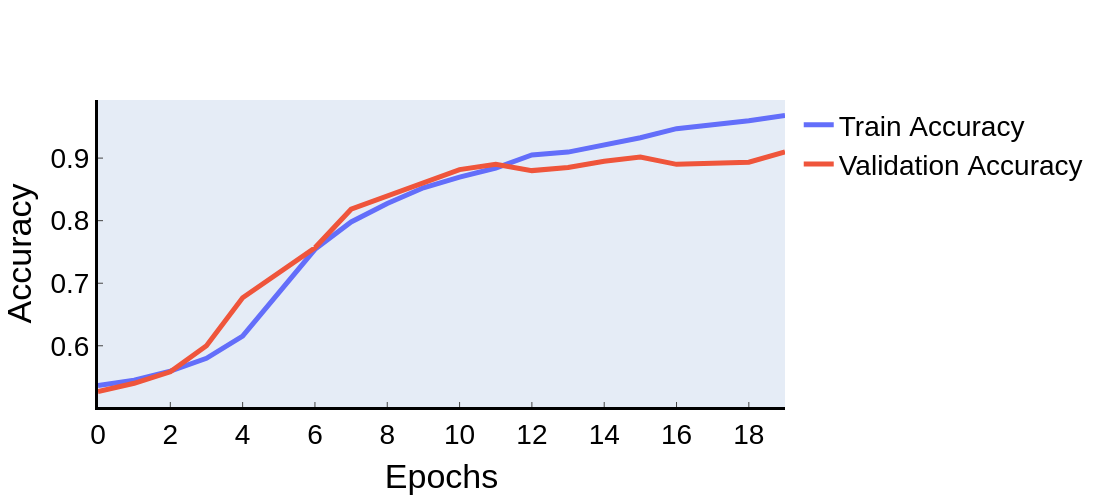

In [28]:
#plotting accuracy vs epochs
acc = his.history['binary_accuracy']
val_acc = his.history['val_binary_accuracy']
x_axis = list(range(epochs))

dimensions = {"height" : 500, "width" :1100}
gridTemplate = {"showgrid":False,
                  "showline":True,
                  "linecolor":"black",
                  "linewidth":3,
                  "ticks":'inside'}

fig = go.Figure()

fig.add_trace(go.Scatter(x=x_axis,y=acc,name="Train Accuracy",line=dict(width=5)))
fig.add_trace(go.Scatter(x=x_axis,y=val_acc,name = "Validation Accuracy",line=dict(width=5)))
fig.update_xaxes(gridTemplate, title_text="Epochs",automargin=True)
fig.update_yaxes(gridTemplate, title_text="Accuracy",automargin=True)
fig.update_layout(dimensions,font=dict(color="black",size=28))
fig.show(renderer="png")

## Saving the Model

In [19]:
#saving the model
save_path = "/content/gdrive/MyDrive/Colab Notebooks/Checkpoints/"
model.save(save_path+"my_model", include_optimizer=False,save_format='tf')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Checkpoints/my_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Checkpoints/my_model/assets


## Loading saved model 

In [20]:
#loading the model
loaded_model = tf.keras.models.load_model(save_path+"my_model")
loaded_model.compile(optimizer = optimizer, loss = loss, metrics = metric)
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None,)]            0                                            
__________________________________________________________________________________________________
preprocess (KerasLayer)         {'input_type_ids': ( 0           input[0][0]                      
__________________________________________________________________________________________________
encoder (KerasLayer)            {'pooled_output': (N 28763649    preprocess[0][0]                 
                                                                 preprocess[0][1]                 
                                                                 preprocess[0][2]                 
______________________________________________________________________________________________


## Testing on my own sentences


In [21]:
testing_sentences = ["I loved the product!",
                    "Whoever thought of this is a genius",
                    "It was ok",
                    "The new appliance sucks",
                     "Stay away from this",
                    "I wont be buying this again"]

results = tf.sigmoid(model(tf.constant(testing_sentences)))

print(results)

tf.Tensor(
[[0.998708  ]
 [0.98679763]
 [0.9549413 ]
 [0.00817585]
 [0.02342434]
 [0.05989915]], shape=(6, 1), dtype=float32)


It looks like classifier works great, giving positive reviews a high logit value and negative reviews low values. 